# Compressed kernel density estimation

In [ ]:
import numpy as np
from fklab.decode import compressed_kde as kde

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")

## construct observations

In [ ]:
# we build a 2D data set by randomly sampling a number of gaussian distributions
# with given centers, standard deviations and number of samples

centers = [
    [20.0, 20.0],
    [70.0, 10.0],
    [60.0, 40.0],
    [50.0, 50.0],
    [30.0, 60.0],
    [45.0, 90.0],
    [80.0, 70.0],
]
deviations = [
    [10.0, 20.0],
    [20.0, 10.0],
    [30.0, 5.0],
    [10.0, 10.0],
    [15.0, 20.0],
    [20.0, 30.0],
    [10.0, 30.0],
]
N = [1500, 1200, 1800, 1600, 2000, 1300, 1500]

data = np.empty((np.sum(N), 2))

idx = 0

for n, center, deviation in zip(N, centers, deviations):
    data[idx : idx + n, :] = np.random.normal(center, deviation, size=(n, 2))
    idx += n

Text(0, 0.5, 'y')

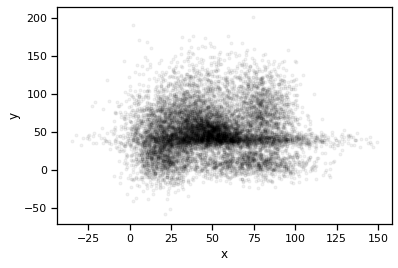

In [ ]:
# plot the data set
plt.plot(data[:, 0], data[:, 1], "ko", alpha=0.05, markersize=3)
plt.xlabel("x")
plt.ylabel("y")

## construct mixture

In [ ]:
# define a 2D euclidean space with labels 'x' and 'y'
# and provide a standard bandwidth for kernels in this space
space = kde.EuclideanSpace(["x", "y"], bandwidth=[5.0, 5.0])

In [ ]:
# create a mixture and set the compression threshold
mix = kde.Mixture(space, 1.0)

In [ ]:
# merge the data points
mix.merge(data)

print(
    "Data is compressed by a factor of {factor} ({n} data points -> {c} components)".format(
        factor=np.sum(N) / mix.ncomponents, c=mix.ncomponents, n=np.sum(N)
    )
)

Data is compressed by a factor of 22.66112266112266 (10900 data points -> 481 components)


## evaluate density

In [ ]:
# construct 2D grid
grid = space.grid([range(-50, 200), range(-50, 200)])

# evaluate density at grid points
p = mix.evaluate(grid)

## plot evaluated density

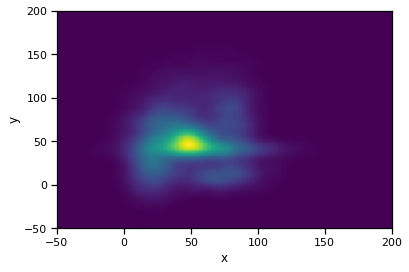

In [ ]:
plt.imshow(
    p.T,
    interpolation="none",
    aspect="auto",
    origin="lower",
    extent=[-50, 200, -50, 200],
    cmap="viridis",
)
plt.xlabel("x")
plt.ylabel("y");

## effect of compression threshold

In [ ]:
# Let's compress the density with varying thresholds
# and look at the compression factor, the time for evaluation
# and how well the compressed density follows the true density

thresholds = [0.0, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]

ncomp = []
eval_time = []
p = []

tmpmix = kde.Mixture(space, 1.0)

for th in thresholds:
    # clear mixture, set new threshold and merge data
    tmpmix.clear()
    tmpmix.threshold = th
    tmpmix.merge(data)

    ncomp.append(tmpmix.ncomponents)

    # evaluate
    p.append(tmpmix.evaluate(grid))

    # time evaluation
    t = %timeit -n3 -r3 -o tmpmix.evaluate( grid )
    eval_time.append(t.best)

1.55 s ± 43.6 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
208 ms ± 4.44 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
65.3 ms ± 906 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
30.5 ms ± 239 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
16.9 ms ± 281 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
10.1 ms ± 2.38 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
1.18 ms ± 27.6 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
477 µs ± 30.9 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


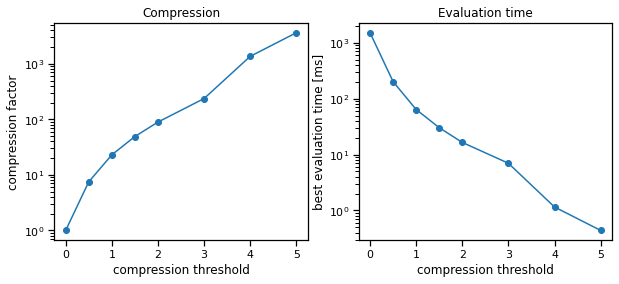

In [ ]:
# assess how compression factor and evaluation time vary with threshold
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

ax[0].plot(thresholds, np.array(np.sum(N) * 1.0 / ncomp), "o-")
ax[0].set_xlabel("compression threshold")
ax[0].set_ylabel("compression factor")
ax[0].set_title("Compression")
ax[0].set_yscale("log")

ax[1].plot(thresholds, 1000.0 * np.array(eval_time), "o-")
ax[1].set_xlabel("compression threshold")
ax[1].set_ylabel("best evaluation time [ms]")
ax[1].set_title("Evaluation time")
ax[1].set_yscale("log")

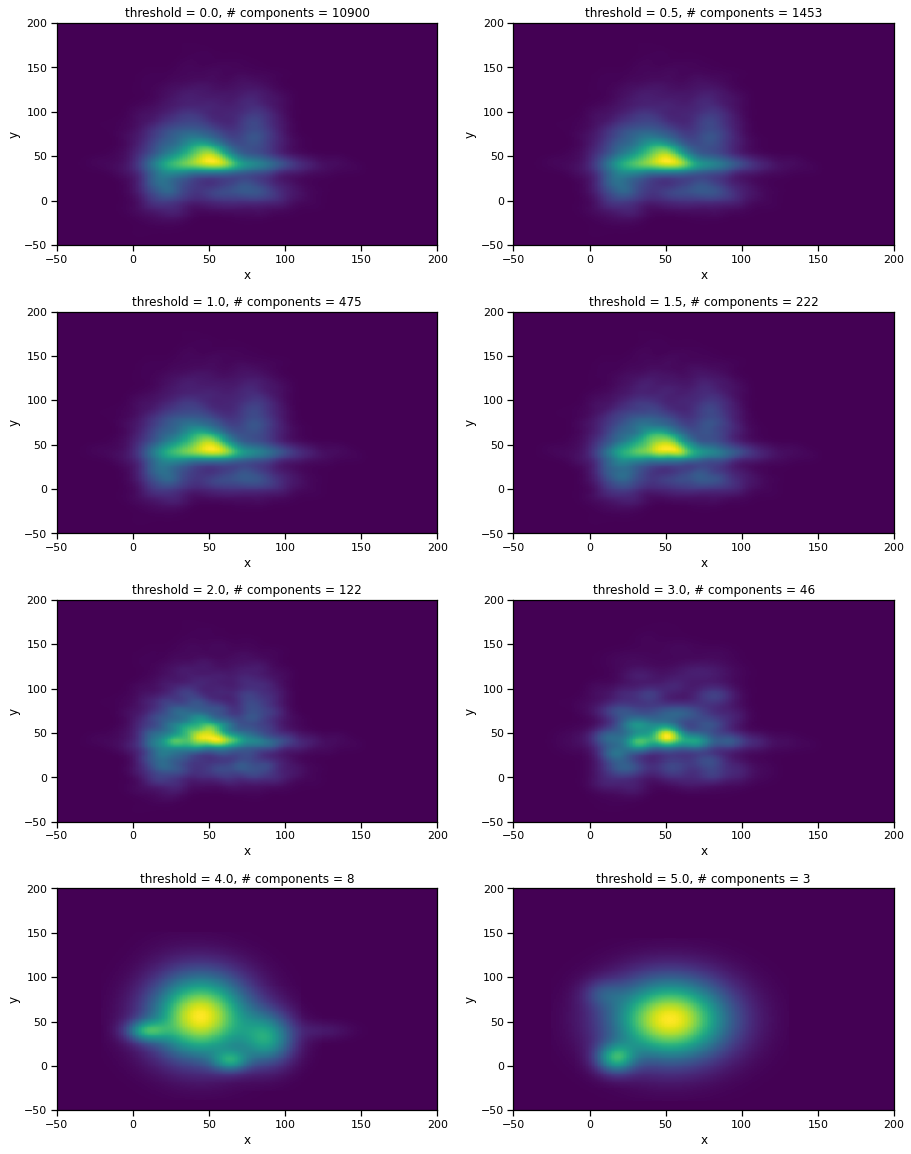

In [ ]:
# let's take a look at the evaluation results
# note that beyond thresholds of 2., the result deviates more and more from the true distribution

fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(15, 20), gridspec_kw={"hspace": 0.3})
ax = ax.ravel()

for k in range(len(thresholds)):
    ax[k].imshow(
        p[k].T,
        interpolation="none",
        aspect="auto",
        origin="lower",
        extent=[-50, 200, -50, 200],
        cmap="viridis",
    )
    ax[k].set_xlabel("x")
    ax[k].set_ylabel("y")
    ax[k].set_title(
        "threshold = {th}, # components = {n}".format(th=thresholds[k], n=ncomp[k])
    )

In [ ]:
# let's define a few functions to quantify the difference between the distributions


def kl(a, b):
    a_sum = np.sum(a)
    b_sum = np.sum(b)
    z = (a / a_sum) * np.log((a / a_sum) / (b / b_sum))
    z[np.isinf(z)] = 0
    return np.nansum(z)


def dist(a, b):
    return np.nansum(np.abs(b - a))


def reldist(a, b):
    return np.nanmean(np.abs(b - a) / (a + b))

/home/jovyan/envs/fkdev/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/jovyan/envs/fkdev/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/home/jovyan/envs/fkdev/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/jovyan/envs/fkdev/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys
/home/jovyan/envs/fkdev/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


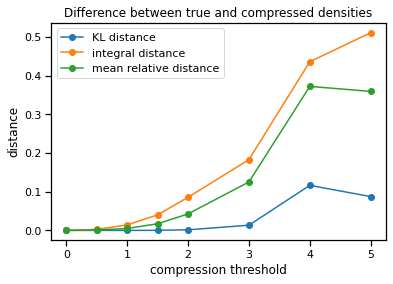

In [ ]:
# and plot the difference between compressed and non-compressed densities
# as a function of the threshold

delta = [kl(p[0], p1) for p1 in p]
plt.plot(thresholds, np.array(delta), "o-", label="KL distance")

delta = [reldist(p[0], p1) for p1 in p]
plt.plot(thresholds, np.array(delta), "o-", label="integral distance")

delta = [dist(p[0], p1) for p1 in p]
plt.plot(thresholds, np.array(delta), "o-", label="mean relative distance")

plt.xlabel("compression threshold")
plt.ylabel("distance")
plt.title("Difference between true and compressed densities")
plt.legend(loc=2)

## partial evaluation

It is possible to partially evaluate the density on a grid over a subspace, and then complete the evaluation at a later point. This is particularly useful in the context of decoding with compressed densities, in which we have a joint distribution of spike amplitudes and behavioral covariates. We would like to partially evaliate the density on a grid defined in the behavioral covariate subspace and then complete the evaluation when new spikes come in.

In [ ]:
# define a grid for the `y` dimension
partial_grid = space.grid([range(-50, 200)], [], [False, True])

# and compute the partial result on this grid
partial = mix.partialize(partial_grid)

In [ ]:
# now, let's complete the density evaluation at a number of points in the x dimension
# note that when completing partially evaluated densities,
# the resulting array has shape < npoints, *grid_shape >

q = partial.complete(np.arange(-50, 200)[:, None])

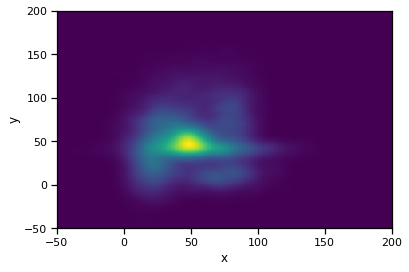

In [ ]:
# verify the result

plt.imshow(
    q.T,
    interpolation="none",
    aspect="auto",
    origin="lower",
    extent=[-50, 200, -50, 200],
    cmap="viridis",
)
plt.xlabel("x")
plt.ylabel("y");

In [ ]:
# let's measure how long it takes to complete the evaluation
x = np.ascontiguousarray(np.arange(-50.0, 200)[:, None])
t = %timeit -n3 -r3 -o partial.complete( x )

9.99 ms ± 2.87 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


## (obsolete) comparison to old gmm code